<a href="https://colab.research.google.com/github/peterkd/DeepLearningProject/blob/main/Recurrent%20LSTM%20Autoencoder/Recurrent_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term Project - Recurrent Autoencoder for IMDB Review Sentiment Classification 

# Table of content
- [0. Introduction](#Intro)
- [1. Script Initialization](#initialization)
- [2. Data Load](#Dataload)
- [3. LSTM Recurrent Autoencoder](#Autoencoder)
- [4. Train the Autoencoder](#TrainEncoder)
- [5. Evaluate the Autoencoder](#EvaluateEncoder)
- [6. Train Sentiment Classifier with Frozen Encoder Layers](#FrozenEncoderSentimentClassifier)
- [7. Evaluate Sentiment Classifier with Frozen Encoder Layers](#TrainModel1)
- [8. Train Sentiment Classifier with Unfrozen Encoder Layers](#UnfrozenEncoderSentimentClassifier) 
- [9. Evaluate Sentiment Classifier with Unfrozen Encoder Layers](#TrainModel2)
- [10. Evaluate Sentiment Classifier](#EvaluateClassifiers)
- [11. Conclusion](#Conc)

# 0. Introduction  <div id='Intro'/>

This module of the project involves sentiment classification of the IMDB movie reviews through training a Recurrent LSTM Autoencoder used for representational learning of sequential data and then transferring the dense encoder layers to a dense neural network (DNN) for classification. A recurrent LSTM autoencoder was used istead of other autoencoder architectures since the ordering of the features (i.e. words) in the sequential text data is important for the ultimate objective of classifying sentiment.

Instead of the standard embedding layer used in Keras, the Recurrent LSTM Autoencoder used in this module inputs the one hot encoded word positions for each movie review (length 100) to learn a dense representation of the IMDB movie reviews with far fewer dimensions than the original input i.e. 50 features. There were only a few resources that use the recurrent autoencoder approach for representation learning. References are at the bottom of this section. Much of the knowledge was drawn from the "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition" textbook GitHub site.

The idea behind the encoder is to compress the feature input to a lower dimensional space from the "bottleneck" of the encoder. The second half or decoder portion of the autoencoder is then used to reconstruct the input. However, for the purposes of this module for classification, the decoder portion is discarded and the encoder which outputs a dense respresentation of the input in a lower dimensional space is used after the autoencoder is trained. The encoder for this module uses 3 hidden layers containing 100, 75 and 50 LSTM cells with the default Tanh activation function.

![Autoencoders.png](attachment:Autoencoders.png)

The trained encoder is then transferred to a new dense neural network to train for sentiment classification using 4 dense hidden layers with 64, 32, 16 and 1 units where the first 3 layers use the SeLu activation and the last layer uses a sigmoid for values between 0 and 1 representing the probability the review is positive. Regularization techniques were applied in addition to the layers to avoid issues around the vanishing gradient and overfitting of the data. These techniques include batch normalization and dropout.

Finally, the results are reviewed to determine if the Encoder is capable of reducing the dimensionality while retaining the key attributes for accurate sentiment classification.

Note: Movie reviews are shortened to 100 words as the sentiment are generally believed to be interpreted from the first few sentences. The same 1,000 word vocabulary is used as the Text Classification with an RNN in TensorFlow:

https://www.tensorflow.org/tutorials/text/text_classification_rnn


#### REFERENCES:<br>
MLH Textbook GitHub site: https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb 
<br>
Additional Resources Online 1:https://machinelearningmastery.com/lstm-autoencoders/
<br>
Additional Resources Online 2:https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

# 1. Import Necessary packages and defined function  <div id='initialization'/>

In [ ]:
#seed
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import random
random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


import keras
keras.__version__ 
import tensorflow as tf 
from keras import models
import h5py
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt 
from tensorflow import keras   
import numpy as np
import tensorflow.keras.backend as K
print(tf.keras.__version__)
import os, os.path, shutil
import time
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout 
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from os import path
import pandas as pd 
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import re
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from sklearn.manifold import TSNE
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import Image

2.4.0


In [ ]:
# Rounded accuracy used for autoencoder training
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# 2. Import the Data File <div id='Dataload'/>

Steps included for processing the data include:
<br>

1) Load the IMDB reviews importing only the top 1000 words similar to the RNN and split the test set from the validation set. <br>
2) Select only the first 100 words of the reviews as the sentiment can often be determined from the first few sentences. The process also pads the review if length <100. <br>
3) One hot encode the reviews so each word is presented as a 1000 vector (vocabulariy size). Each review will then be 100 x 1000 or review length x vocabulary size. This is important in order to allow the model to scale the input data properly during training.

### 1) Load the data.

In [ ]:
# select the top 1000 in the vocabulary for the IMDB dataset
top_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
(all_X_train, _), (all_X_valid, _) = imdb.load_data() # For all review words

# Split the test set from the validation
X_Valid, X_Test = X_test[:-5000], X_test[-5000:]
y_Valid, y_Test= y_test[:-5000], y_test[-5000:]
 

In [ ]:
# Summarize number of words
print("Number of unique words in training set: ")
print(len(np.unique(np.hstack(X_train))))
print("Number of unique words in validation set: ")
print(len(np.unique(np.hstack(X_Valid))))
print("Number of unique words in test set: ")
print(len(np.unique(np.hstack(X_Test)))) 

Number of unique words in training set: 
998
Number of unique words in validation set: 
998
Number of unique words in test set: 
998


In [ ]:
print("Number of records in Train set: " + str (X_train.shape))
print("Number of records in Validation set: " + str (X_Valid.shape))
print("Number of records in Test set: " + str (X_Test.shape)) 
print("Classes: " + str(np.unique(y_train)))

Number of records in Train set: (25000,)
Number of records in Validation set: (20000,)
Number of records in Test set: (5000,)
Classes: [0 1]


<b> Observations: </b> Two unique classes which are 0 for negative and 1 for positive.

### 2) Pad and fix the review size to 100.

 Select the first 100 words for the review and Pad the reviews with 0's if < 100  to ensure they are all of length 100 if not already. 

In [ ]:
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_Valid = sequence.pad_sequences(X_Valid, maxlen=max_review_length)
X_Test = sequence.pad_sequences(X_Test, maxlen=max_review_length) 

### 3) One hot encode the reviews.

In [ ]:
# one hot encode training data
X_train_encoded = to_categorical(X_train)
# one hot encode validation data
X_Valid_encoded = to_categorical(X_Valid)
# one hot encode test data
X_Test_encoded = to_categorical(X_Test) 

In [ ]:
print("Train set shape: " + str (X_train_encoded.shape))
print("Validation set shape: " + str (X_Valid_encoded.shape)) 
print("Test set shape: " + str (X_Test_encoded.shape)) 

Train set shape: (25000, 100, 1000)
Validation set shape: (20000, 100, 1000)
Test set shape: (5000, 100, 1000)


In [ ]:
# Our vectorized labels 
y_Valid    = np.asarray(y_Valid).astype('float32') 
y_Test     = np.asarray(y_Test).astype('float32')
y_train    = np.asarray(y_train).astype('float32') 

# 3. Create the Reconstruction LSTM Recurrent Autoencoder <div id='Autoencoder'/>

When compiling the stacked autoencoder, we used the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each word in the vocabulary at a position in the review represents the probability that the word will be oberved. The autoencoder will converge faster  when framed as a binary classification problem as stated  in  the MLH textbook.

The bottleneck of the encoder outputs a vector of length 50 which is substantially smaller than the original input of 100 x 1000. The encoder uses LSTM with default tanh activation throughout the network. The last layer uses a sigmoid activation for a value between 0 and 1 representing a probability of the word being in the review.

Note, L1 Normalization was also used in the final layer of the encoder but was found not to be effective in improving model performance. Also, larger network sizes were considered as well but the processing time greatly limited how deep to extend the model.

In [ ]:
# The subset for training the recurrent autoencoder is balanced.
np.unique(y_train, return_counts=True) 

(array([0., 1.], dtype=float32), array([12500, 12500]))

In [ ]:
# Encoder
recurrent_encoder = keras.models.Sequential([ 
    keras.layers.LSTM(100,  return_sequences=True, #Tanh activation for hidden layer. 
                      input_shape=[max_review_length, top_words]), #lower dim. from input return seq. to next layer.
    keras.layers.LSTM(75 ,  return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.LSTM(50), #Tanh activation for hidden layer with the lowest number of units (50)
])

# Decoder
recurrent_decoder = keras.models.Sequential([ 
    keras.layers.RepeatVector(max_review_length, input_shape=[50]), # RepeatVector is first, so input fed at each time step.
    keras.layers.LSTM(75,  return_sequences=True),  #Tanh activiation for hidden layer.   
    keras.layers.LSTM(100,   return_sequences=True), #Tanh activiation for hidden layer.  
    keras.layers.TimeDistributed(keras.layers.Dense(top_words, activation = 'sigmoid')) # sigmoid act. as output from 0 to 1.
])
    
# Combine the Encoder and Decoder to create the AutoEncoder model.
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

#Compile the model.
recurrent_ae.compile(loss="binary_crossentropy", optimizer= keras.optimizers.Adam(0.0001), # use the standard learning_rate=0.0001
                     metrics=[rounded_accuracy])


# save best parameter estimate using val loss.
checkpointer_ae = ModelCheckpoint("Recurrent_AutoEncoder_ModelNEW.hdf5", monitor="val_loss", mode="auto", #monitor training loss
                               save_best_only = True, verbose=1)

# save the training history.
csv_logger_ae = CSVLogger('RecurrentAENEW.log', separator=',', append=False) 

# compile the callbacks together
callbackser_ae = [checkpointer_ae, csv_logger_ae]

#BaseModel.summary()

In [ ]:
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                518400    
_________________________________________________________________
sequential_1 (Sequential)    (None, 100, 1000)         209200    
Total params: 727,600
Trainable params: 727,600
Non-trainable params: 0
_________________________________________________________________


# 4. Train the Recurrent Autoencoder <div id='TrainEncoder'/>

The LSTM Recurrent Autoencoder is fitted based on reconstruction of the input training data and evaluated on new instances 
using the validate training set. The Autoencoder is trained using batch sizes of 50 and for 20 epochs over the 
training set. Model weights for the epoch with the lowest validation loss are saved.

In [ ]:
start_time = time.time() 
history_ae = recurrent_ae.fit(X_train_encoded , X_train_encoded , epochs=20, batch_size = 50,
                              validation_data=(X_Valid_encoded , X_Valid_encoded ), callbacks = callbackser_ae)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.1912 - rounded_accuracy: 0.9740
Epoch 00001: val_loss improved from inf to 0.03476, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
500/500 [==============================] - 448s 896ms/step - loss: 0.1912 - rounded_accuracy: 0.9740 - val_loss: 0.0348 - val_rounded_accuracy: 0.9990
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.0220 - rounded_accuracy: 0.9990
Epoch 00002: val_loss improved from 0.03476 to 0.01476, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
500/500 [==============================] - 451s 902ms/step - loss: 0.0220 - rounded_accuracy: 0.9990 - val_loss: 0.0148 - val_rounded_accuracy: 0.9990
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.0119 - rounded_accuracy: 0.9990
Epoch 00003: val_loss improved from 0.01476 to 0.00993, saving model to Recurrent_AutoEncoder_ModelNEW.hdf5
500/500 [==============================] - 446s 891ms/step - loss:

# 5. Evaluate the Recurrent AutoEncoder <div id='EvaluateEncoder'/>

In [ ]:
# retrieve the best model weights.
recurrent_ae.load_weights("Recurrent_AutoEncoder_ModelNEW.hdf5")

history_ae = pd.read_csv('RecurrentAENEW.log', sep=',', engine='python') 

### Plot the training/validation binary cross entropy loss performance

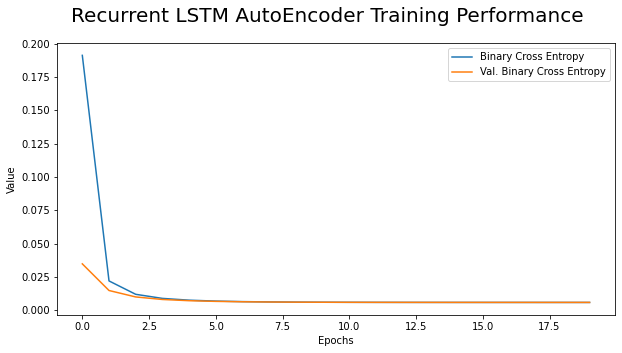

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_ae['epoch'],history_ae['loss'])
plt.plot(history_ae['epoch'], history_ae['val_loss']) 
plt.suptitle('Recurrent LSTM AutoEncoder Training Performance', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(['Binary Cross Entropy', 'Val. Binary Cross Entropy' 
           ]) 

<b> Observations: </b> The model converged quickly with little improvement after the 10th epoch.

### Visualize the Encoder Compressed IMDB Movie Reviews with t-SNE 

We use the t-distributed stochastic neighbor embedding (t-SNE) in order to visualize the output of the recurrent encoder.

In [ ]:
start_time = time.time() 
X_train_RE_compressed = recurrent_encoder.predict(X_train_encoded) # obtain the encoder output from the training set
tsne_Encoder_RE = TSNE(perplexity = 40, learning_rate = 500) #Specify the t-SNE configuration.
X_train_2D_RE = tsne_Encoder_RE.fit_transform(X_train_RE_compressed) # Fit t-SNE to the training data.
X_train_2D_RE = (X_train_2D_RE - X_train_2D_RE.min()) / (X_train_2D_RE.max() - X_train_2D_RE.min()) #normalize
print('---- %s seconds to train t-SNE ----' % (time.time() - start_time))

---- 454.8281321525574 seconds to train t-SNE ----


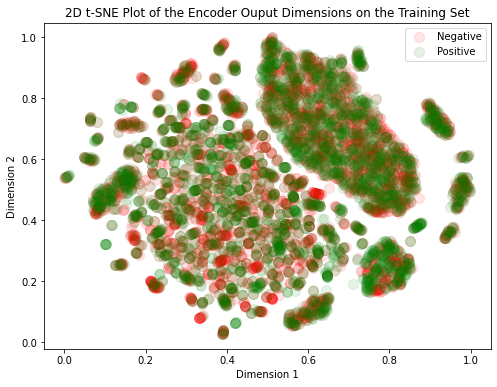

In [ ]:
# Plot the last 7,500 rreviews in the dataset
X_train_2D_RE_PLOT = X_train_2D_RE[-7500:]
y_train_RE_PLOT = y_train[-7500:]

# color code the sentiment for each review. Green for positve and red for negative.
cdict = {'Negative': 'red', 'Positive' : 'green'}
sentiment = ['Positive' if x == 1 else 'Negative' for x in y_train_RE_PLOT]
 
#Create a scatterplot of the 2 dimenional output from t-SNE
#fig, ax = plt.subplots()
plt.figure(figsize=(8,6))
for g in np.unique(sentiment):
    #print(g)
    ix = np.where(np.array(sentiment) == g)
    plt.scatter(X_train_2D_RE_PLOT[ix,0], X_train_2D_RE_PLOT[ix,1], c = cdict[g], 
               label = g, s = 100, alpha = 0.1 )
plt.title("2D t-SNE Plot of the Encoder Ouput Dimensions on the Training Set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

<b> Observations: </b> The encoder appears to find distinct clusters in the review data but they do not seem sentiment specific. 
The less dense larger cloud in the middle of the plot could arguably be interpreted as being more negative in 
sentiment with more of the red standing out despite the green positive reviews have been overlayed on top.

# 6. Sentiment Classification DNN with the frozen encoder from the Recurrent Autoencoder.  <div id='FrozenEncoderSentimentClassifier'/>

The DNN uses a cloned copy of the encoder layers in the Recurrent Autoencoder from the previous sections which is also frozen to determine whether an effective sentiment classifier could be built on top. 

In order to reduce any issues around overfitting the model is regularized through introducing batch normalization at each layer in the model and dropout with a 50% keep probability in the final layer of the model. 

The model also addressed the vanishing gradient through appropriate kernel intializers which in this case in the LeCun Normal when the SeLu is used for activation. The standard ADAM optimizer is used as it is known to be an effective optimizer using the default parameters.

In [ ]:
# Clone the encoder from the Autoencoder model
recurrent_encoder_clone   = keras.models.clone_model(recurrent_encoder)
# recurrent_encoder_clone = model.layers[i].get_weights()

# Configure the sentiment classification model
Sentiment_clf = keras.models.Sequential([
    recurrent_encoder_clone,
    keras.layers.Flatten(), 
    keras.layers.Dense(64,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(32,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    keras.layers.Dense(16,  activation=None, kernel_initializer = tf.keras.initializers.LecunNormal()),
    layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
    layers.Activation(activation="selu"), # Add selu activation layer 
    Dropout(rate=0.5), # Regularize the final layer with 50% dropout rate.
    keras.layers.Dense(1, activation="sigmoid", kernel_initializer = tf.keras.initializers.GlorotNormal())
])

# Freeze the encoder layer 
Sentiment_clf.layers[0].trainable = False  

#Compile the model.
Sentiment_clf.compile(loss="binary_crossentropy", 
                      optimizer= keras.optimizers.Adam(0.001), # use ADAM optimization. 
                      metrics=[metrics.binary_accuracy])


# save best parameter estimate using val loss.
checkpointer_se = ModelCheckpoint("Encoder_Sentiment_Model.hdf5", monitor="val_loss", mode="auto",#monitor valid. loss
                                  save_best_only = True, verbose=1)

# save the training history.
csv_logger_se = CSVLogger('EncoderSM.log', separator=',', append=False) 

# compile the callbacks together
callbackser_se = [checkpointer_se, csv_logger_se]

In [ ]:
Sentiment_clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50)                518400    
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

# 7. Train the Encoder Sentiment Classifier with the frozen Encoder Layers <div id='TrainModel1'/>

The Sentiment classifier is trained using batch sizes of 50 and for 10 epochs over the training set.

In [ ]:
start_time = time.time() 
history_se = Sentiment_clf.fit(X_train_encoded, y_train, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_encoded, y_Valid), callbacks = callbackser_se)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.7467 - binary_accuracy: 0.5245
Epoch 00001: val_loss improved from inf to 0.68760, saving model to Encoder_Sentiment_Model.hdf5
500/500 [==============================] - 143s 286ms/step - loss: 0.7467 - binary_accuracy: 0.5245 - val_loss: 0.6876 - val_binary_accuracy: 0.5411
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.6891 - binary_accuracy: 0.5522
Epoch 00002: val_loss improved from 0.68760 to 0.67784, saving model to Encoder_Sentiment_Model.hdf5
500/500 [==============================] - 141s 282ms/step - loss: 0.6891 - binary_accuracy: 0.5522 - val_loss: 0.6778 - val_binary_accuracy: 0.5756
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.6797 - binary_accuracy: 0.5707
Epoch 00003: val_loss did not improve from 0.67784
500/500 [==============================] - 144s 288ms/step - loss: 0.6797 - binary_accuracy: 0.5707 - val_loss: 0.6782 - val_binary_accuracy: 0.

In [ ]:
# retrieve the best model weights.
Sentiment_clf.load_weights("Encoder_Sentiment_Model.hdf5")

history_se = pd.read_csv('EncoderSM.log', sep=',', engine='python')

<b> Observations: </b> The model validation loss is much higher and accuracy much lower than the base model performance from the tutorial i.e. 0.68 and 0.32 binary cross entropy loss and 0.58 and 0.86 for accuracy. The frozen pretrained encoder layers appear to provide a modest representation of the reviews for sentiment prediction. This indicates the pre-trained encoder layers used will likely need to be fine-tuned with the dense classification layers to improve model sentiment predictions. The sentiment classifier is further trained but with the encoder layers set to trainable and the ADAM learning rate lowered to 0.00001 as the encoder weights have already been trained on the training set data. 

# 8. Sentiment Classification DNN with the unfrozen encoder from the Recurrent Autoencoder.  <div id='UnfrozenEncoderSentimentClassifier'/>

The same model is compiled again but the encoder layers are now trainable and the learning rate has been lowered to 0.00001 for the ADAM optimizer. A lower learning rate is used in order to stabilize the change in binary cross entropy during training. Also, the encoder model weights have already been trained to learn a representation of the reviews.

In [ ]:
# Set the recurrent encoder layers to be trainable for this iteration.
recurrent_encoder_clone.trainable = True
# compile the model again.
Sentiment_clf.compile(loss="binary_crossentropy", 
                      optimizer= keras.optimizers.Adam(0.00001), # lower learning rate as the encoder is pretrained
                      metrics=[metrics.binary_accuracy]) 

# save best parameter estimate using val loss.
checkpointer_se2 = ModelCheckpoint("Encoder_Sentiment_Model2.hdf5", 
                                   monitor="val_loss", mode="auto",#monitor valid. loss
                                  save_best_only = True, verbose=1)

# save the training history.
csv_logger_se2 = CSVLogger('EncoderSM2.log', separator=',', append=False) 

# compile the callbacks together
callbackser_se2 = [checkpointer_se2, csv_logger_se2]

# 9. Train the Encoder Sentiment Classifier with the Unfrozen Encoder Layers <div id='TrainModel2'/>

The Sentiment classifier is trained using batch sizes of 50 and for 10 epochs over the training set.

In [ ]:
start_time = time.time() 
history_se2 = Sentiment_clf.fit(X_train_encoded, y_train, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_encoded, y_Valid), callbacks = callbackser_se2)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.6622 - binary_accuracy: 0.6053
Epoch 00001: val_loss improved from inf to 0.65590, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 249s 497ms/step - loss: 0.6622 - binary_accuracy: 0.6053 - val_loss: 0.6559 - val_binary_accuracy: 0.6158
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.6452 - binary_accuracy: 0.6364
Epoch 00002: val_loss improved from 0.65590 to 0.63916, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 249s 498ms/step - loss: 0.6452 - binary_accuracy: 0.6364 - val_loss: 0.6392 - val_binary_accuracy: 0.6460
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.6275 - binary_accuracy: 0.6639
Epoch 00003: val_loss improved from 0.63916 to 0.62321, saving model to Encoder_Sentiment_Model2.hdf5
500/500 [==============================] - 247s 495ms/step - loss: 0.6275 - binary_accuracy

<b> Observations: </b> The training log shows the validation loss was still improving the by the 10th epoch. The model is further trained for an additional 10 epochs. 

### Training Session 2

In [ ]:
#Resume training
start_time = time.time() 
# save best parameter estimate using val loss.
checkpointer_se2_2 = ModelCheckpoint("Encoder_Sentiment_Model2_2.hdf5", monitor="val_loss", #monitor valid. loss
                                     mode="auto", save_best_only = True, verbose=1)
# save the training history.
csv_logger_se2_2 = CSVLogger('EncoderSM2_2.log', separator=',', append=False) 
# compile the callbacks together
callbackser_se2_2 = [checkpointer_se2_2, csv_logger_se2_2]

history_se2 = Sentiment_clf.fit(X_train_encoded, y_train, epochs=10, batch_size = 50,
                               validation_data=(X_Valid_encoded, y_Valid), callbacks = callbackser_se2_2)

print('---- %s seconds to evaluate the whole dataset ----' % (time.time() - start_time))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.4942 - binary_accuracy: 0.7927
Epoch 00001: val_loss improved from inf to 0.49057, saving model to Encoder_Sentiment_Model2_2.hdf5
500/500 [==============================] - 261s 521ms/step - loss: 0.4942 - binary_accuracy: 0.7927 - val_loss: 0.4906 - val_binary_accuracy: 0.7768
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.4750 - binary_accuracy: 0.8040
Epoch 00002: val_loss did not improve from 0.49057
500/500 [==============================] - 257s 515ms/step - loss: 0.4750 - binary_accuracy: 0.8040 - val_loss: 0.4947 - val_binary_accuracy: 0.7611
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8135
Epoch 00003: val_loss improved from 0.49057 to 0.48393, saving model to Encoder_Sentiment_Model2_2.hdf5
500/500 [==============================] - 268s 536ms/step - loss: 0.4573 - binary_accuracy: 0.8135 - val_loss: 0.4839 - val_binary_accura

In [ ]:
# retrieve the best model weights.
Sentiment_clf.load_weights("Encoder_Sentiment_Model2_2.hdf5")
# load the training history for the sentiment classifier model.
history_se2_1 = pd.read_csv('EncoderSM2.log', sep=',', engine='python')
history_se2_2 = pd.read_csv('EncoderSM2_2.log', sep=',', engine='python') 
history_se2  = pd.concat([history_se2_1, history_se2_2]).reset_index(drop=True)
#history_se2
history_se2['epoch'] = list(range(len(history_se2)))

In [ ]:
history_se2

,epoch,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0,0.60532,0.662241,0.61575,0.655903
1,1,0.63644,0.645241,0.64595,0.639165
2,2,0.66392,0.627535,0.66615,0.623211
3,3,0.68608,0.611495,0.68365,0.606466
4,4,0.70868,0.595001,0.70215,0.590481
5,5,0.72248,0.577604,0.71420,0.575300
6,6,0.73640,0.563394,0.72790,0.559424
7,7,0.75284,0.546526,0.72875,0.548320
8,8,0.76608,0.528929,0.75475,0.524851
9,9,0.77832,0.512874,0.75535,0.515141


# 10. Evaluate the Encoder Sentiment Classifier <div id='EvaluateClassifiers'/>

In [ ]:
# retrieve the best model history for comparison.  
base_history = pd.read_csv('trainingBaseModel.log', sep=',', engine='python')

### Plot the training/validation loss and Accuracy training performance

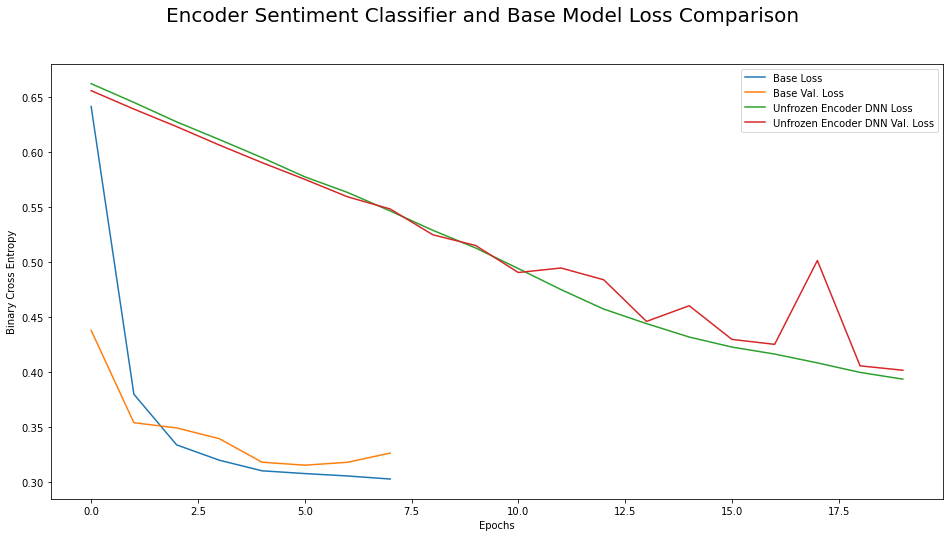

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(base_history['loss'])
plt.plot(base_history['val_loss'])
plt.plot(history_se2['loss'])
plt.plot(history_se2['val_loss']) 
plt.suptitle('Encoder Sentiment Classifier and Base Model Loss Comparison', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Binary Cross Entropy')
plt.legend(['Base Loss', 'Base Val. Loss', 
            'Unfrozen Encoder DNN Loss', 'Unfrozen Encoder DNN Val. Loss'])


<b> Observations: </b> The encoder classifier with trainable encoder layers appears to be approx. converged by the 20th epoch. The training/validation loss is moderately higher than the base model from the TensorFlow tutorial i.e. 0.40 vs. 0.33 for the encoder classifier and base model respectively. 

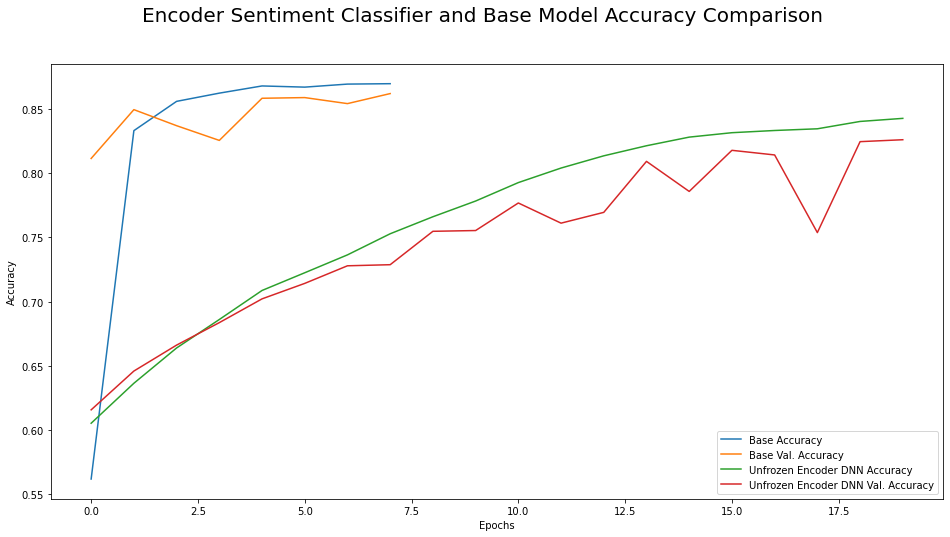

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(base_history['accuracy'])
plt.plot(base_history['val_accuracy'])
plt.plot(history_se2['binary_accuracy'])
plt.plot(history_se2['val_binary_accuracy'])
plt.suptitle('Encoder Sentiment Classifier and Base Model Accuracy Comparison', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Base Accuracy', 'Base Val. Accuracy', 
            'Unfrozen Encoder DNN Accuracy', 'Unfrozen Encoder DNN Val. Accuracy'])
#plt.savefig('SM_Loss_MSE_Training_FINAL.png')

<b> Observations: </b> The encoder classifier with trainable encoder layers reached a maximum validation accuracy of 0.83 towards the 20th epoch which is moderately lower than the base model at 0.86.

 ### Create a confusion matrix for the validation set

In [ ]:
# Predict the sentiment for the test set
y_pred_Valid = np.round(Sentiment_clf.predict(X_Valid_encoded))

[[8251 1802]
 [1677 8270]]


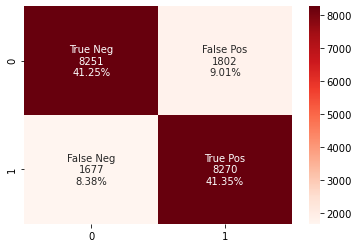

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_Valid, y_pred_Valid)
print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

<b> Observations: </b> The validation accuracy suggests the false positives and false negatives are balanced between the two groups with 82% precision and 83% recall.

### Evaluate the test set accuracy.

In [ ]:
# Evaluate the test set.
test_loss, test_acc = Sentiment_clf.evaluate(X_Test_encoded, y_Test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

157/157 [==============================] - 23s 148ms/step - loss: 0.4043 - binary_accuracy: 0.8198
Test Loss: 0.4042503237724304
Test Accuracy: 0.8198000192642212


<b> Observations: </b> Similar to the validation, the encoder sentiment classifier with trainable encoder layers yielded a lower test accuracy (0.82) than the RNN base model from the TensorFlow tutorial (0.86).

# 11. Conclusion <div id='Conc'/>

Overall, the dense representation of the reviews from the encoder output of the Recurrent LSTM Autoencoder resulted in a modest ability for the DNN classifier to predict sentiment when the encoder layers were frozen during training. This suggests the encoder may have only captured a partial representation of the sentiment structure in the IMDB movie reviews. By fine-tuning the encoder layers during the DNN sentiment classifier training, the model was then able to substantially reduce the loss and enhance the accuracy prediction to only moderately underperform relative to the base model.

Future work could be to enhance the pre-trained Recurrent autoencoder by increasing computational power to train the autoencoder for several epochs and for more hidden LSTM layers and cells. Also, the vocabulary size could be increased from the 1,000 used in the tutorial to capture more of the relationships between unique words in the dataset and how it pertains to sentiment of the review. These adjustments could yield a pre-trained LSTM recurrent encoder that produces a higher validation accuracy without requiring fine-tuning when training the DNN classifier.